Epoch 1/20


E:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0553 - val_loss: 0.0135
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0105 - val_loss: 0.0143
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0096 - val_loss: 0.0145
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0108 - val_loss: 0.0130
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0105 - val_loss: 0.0128
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0092 - val_loss: 0.0125
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0098 - val_loss: 0.0139
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0095 - val_loss: 0.0131
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0093 - val_loss: 0.0124
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0092 - val_loss: 0.0165
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/st

C:\Users\thota\AppData\Local\Temp\ipykernel_44956\1817335600.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_input[0, -1, 0] = pred
C:\Users\thota\AppData\Local\Temp\ipykernel_44956\1817335600.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_input[0, -1, 0] = pred


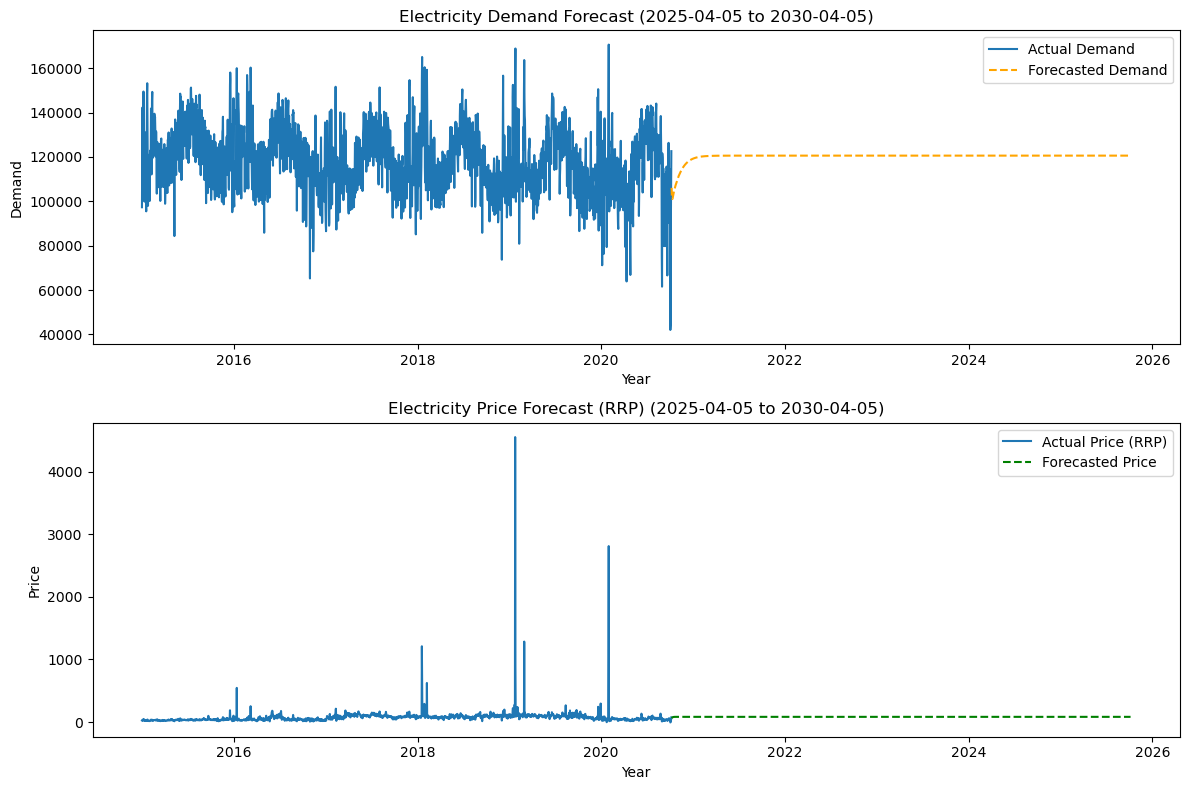

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# Load Dataset
file_path = "final_dataset.csv"
df = pd.read_csv(file_path)

# Ensure Date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Select Relevant Features
df = df[['date', 'demand_pos_RRP', 'RRP']]  # Using demand & RRP (price)

# Normalize Data
scaler_demand = MinMaxScaler()
scaler_price = MinMaxScaler()

df['demand_scaled'] = scaler_demand.fit_transform(df[['demand_pos_RRP']])
df['price_scaled'] = scaler_price.fit_transform(df[['RRP']])

# Define Sequence Length
seq_length = 30  # Using past 30 days to predict next

# Function to Create Sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Prepare Data for Demand Forecasting
demand_data = df['demand_scaled'].values
X_demand, y_demand = create_sequences(demand_data, seq_length)

# Prepare Data for Price Forecasting
price_data = df['price_scaled'].values
X_price, y_price = create_sequences(price_data, seq_length)

# Reshape for LSTM
X_demand = X_demand.reshape(X_demand.shape[0], X_demand.shape[1], 1)
X_price = X_price.reshape(X_price.shape[0], X_price.shape[1], 1)

# Split Train-Test Data
train_size = int(0.8 * len(X_demand))
X_train_demand, X_test_demand = X_demand[:train_size], X_demand[train_size:]
y_train_demand, y_test_demand = y_demand[:train_size], y_demand[train_size:]

X_train_price, X_test_price = X_price[:train_size], X_price[train_size:]
y_train_price, y_test_price = y_price[:train_size], y_price[train_size:]

# Build LSTM Model Function
def build_lstm():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Demand Model
model_demand = build_lstm()
model_demand.fit(X_train_demand, y_train_demand, epochs=20, batch_size=16, validation_data=(X_test_demand, y_test_demand), verbose=1)

# Train Price Model
model_price = build_lstm()
model_price.fit(X_train_price, y_train_price, epochs=20, batch_size=16, validation_data=(X_test_price, y_test_price), verbose=1)

# Function to Forecast Future Values
def forecast(model, data, scaler, forecast_days):
    pred_input = data[-seq_length:].reshape(1, seq_length, 1)
    predictions = []

    for _ in range(forecast_days):
        pred = model.predict(pred_input, verbose=0)
        predictions.append(pred[0][0])

        # Update input sequence for next prediction
        pred_input = np.roll(pred_input, shift=-1, axis=1)  
        pred_input[0, -1, 0] = pred  

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# **🔹 USER INPUT: Select Forecast Range from Calendar**
start_date = datetime(2025, 4, 5)  # Example start date (User Input)
end_date = datetime(2030, 4, 5)    # Example end date (User Input)

# Calculate Forecast Days based on selection
forecast_days = (end_date - start_date).days  # Number of days to predict

# Forecast Future Demand and Price
forecasted_demand = forecast(model_demand, demand_data, scaler_demand, forecast_days)
forecasted_price = forecast(model_price, price_data, scaler_price, forecast_days)

# Generate Future Dates for Forecast
future_dates = [df['date'].max() + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Visualization
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot Demand Forecast
ax[0].plot(df['date'], df['demand_pos_RRP'], label="Actual Demand")
ax[0].plot(future_dates, forecasted_demand, linestyle="dashed", color="orange", label="Forecasted Demand")
ax[0].set_title(f"Electricity Demand Forecast ({start_date.date()} to {end_date.date()})")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Demand")
ax[0].legend()

# Plot Price Forecast
ax[1].plot(df['date'], df['RRP'], label="Actual Price (RRP)")
ax[1].plot(future_dates, forecasted_price, linestyle="dashed", color="green", label="Forecasted Price")
ax[1].set_title(f"Electricity Price Forecast (RRP) ({start_date.date()} to {end_date.date()})")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Price")
ax[1].legend()

plt.tight_layout()
plt.show()